# Zadanie domowe - implementacja algorytmu NSGA-II

Zrealizowali:
<ol>
  <li>Filip Marciniak 148148</li>
  <li>Szymon Pasternak 148146</li>
</ol>

In [1]:
# Import niezbędnych bibliotek
# inline = pozwala wykreślać wykresy biblioteki matplotlib w okienkach jupytera
%matplotlib inline 
import matplotlib.pyplot as plt
import numpy as np

In [2]:
### Klasa Solution
class Solution:
    def __init__(self, x, f, name):
        self.x = x ### zmienne decyzyjne
        self.f = f ### wektor ocen [f1, f2]
        self.front = 0 ## pomocnicza wartość przechowująca numer niezdominowanego frontu
        self.cd = 0.0 ## pomocnicza wartość przechowująca wartość crowding distance
        self.name = name ### pomocnicza nazwa rozwiązania

    def __str__(self):
        return "[" + self.name + " : F = " + str(self.f) + "]"

In [3]:
### TODO należy uzupełnić funkcję obliczającą realizacjię kryteriow w oparciu o informacje w pliku PDF
### wejście = wektor zmiennych decyzyjnych; wyjście = wektor ocen
# Ewluacja rozwiazaąnia w oparciu o zmienne decyzyjne

def evaluate(x):
    l = 1 + abs(x[1]**10 - 0.5) + x[2] + x[3] + x[4]
    return [x[0]**10 * l, (1-x[0]**10)*l]

In [4]:
### Procedura tworzy populacje początkowa o zadanym rozmiarze N
def constructInitialPopulation(N):
    P = []
    for i in range(N):
        x = [j for j in range(5)] 
        x[0] = np.random.rand()
        x[1] = np.random.rand()      
        for j in range(2,5): x[j] = np.random.randint(0,2)
        f = evaluate(x) ### ewaluacja rozwiązania
        P.append(Solution(x, f, str(0)+"-"+str(i))) ### dodanie rozwiązania do listy, 
        # nazwa składa się z dwóch członów: numer generacji, 
        # w której rozwiązanie zostało wygenerowane oraz numer rozwiązania w populacji
    return P

P = constructInitialPopulation(10000)
for s in P[:10]: print(s) ### Wypisanie przykładowych rozwiązań (dla testu)

[0-0 : F = [0.0055730300662537565, 2.211420389166324]]
[0-1 : F = [1.684881864202568, 1.8151181351863237]]
[0-2 : F = [0.04361514526187368, 3.4563848547339795]]
[0-3 : F = [0.029705351230767774, 4.465488338093423]]
[0-4 : F = [0.02761245243556402, 4.461684038562704]]
[0-5 : F = [1.846301907693936e-06, 2.499995935679869]]
[0-6 : F = [0.26324474697909617, 2.236754620612365]]
[0-7 : F = [2.7441039690587265e-09, 2.4938722986284287]]
[0-8 : F = [0.4934522786353326, 2.0065477213614415]]
[0-9 : F = [0.3153263390781094, 2.1808292304010326]]


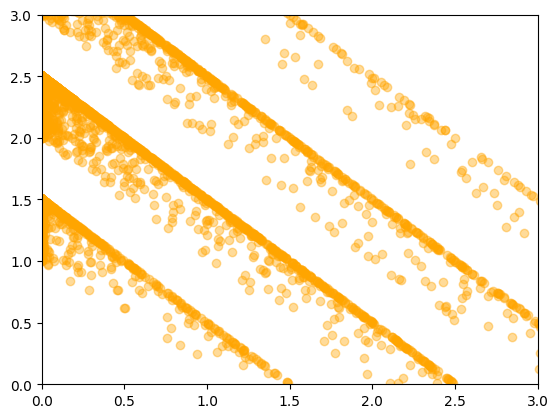

In [5]:
### Poniższa funkcja wykreśla rozwiązania w P wykorzystując wykres punktowy. 
### Przy dużym rozmiarze N można zaobserwowa jak losowo wygenerowane rozwiązania 
### rozkładają się w przestrzeni ocen. Proszę sprawdzić np. dla N=10000. 
### TODO Proszę uzasadnić uzyskany rozkład odwołując się do definicji problemu (funkcji ocen)

# Pierwszą obserwacją jest to, że na wykresie widoczne są charakterystyczne "skoki". Każdy kolejny "przeskok" jest skutkiem tego, że w zmiennej `l` dodawana jest jedna ze zmiennych binarnych (x3, x4, x5).
# Druga obserwacja dotyczy rozproszenia w ramach jednego "skoku". Rozproszenie to spowodowane jest różnymi wartościami x2.

def plotPopul(P):
    plt.figure()
    X = [s.f[0] for s in P]
    Y = [s.f[1] for s in P]
    plt.scatter(X, Y, alpha=0.4, c='orange')
    plt.xlim(0, 3.0);
    plt.ylim(0, 3.0)

plotPopul(P)

In [6]:
### TODO poniższa funkcja winna zwracać listę par indeksów rozwiązań wybranych do reprodukcji.
### Z każdej pary zostanie utworzone jedno rozwiązanie potomne. 
### Selekcja powinna odbywać się w oparciu o turniej o rozmiarze 2
### Wyjście: lista par -> [ [idx11, idx12],...,[idxN1, idxN2] ]
import random

def constructParents(N):
    def tournament(idxs):
        return min(random.sample(idxs, 2))

    def get_parents(N):
        available = list(range(N))
        first = tournament(available)
        available.remove(first)
        second = tournament(available)
        return [first, second]
        
    return [get_parents(N) for _ in range(0, N)]

print(constructParents(10)) ### TEST

[[0, 3], [0, 7], [4, 3], [1, 2], [7, 0], [1, 3], [1, 0], [5, 0], [2, 0], [0, 1]]


In [7]:
# TODO poniższa funkcja powinna dokonywać krzyżowania dwóch wejściowych wektorów
# zmiennych decyzyjnych. Procedura może zostać zaimplementowana w dowolny sposób
# Sugerowane najprostsze rozwiązanie: "potomek" przy określaniu wartości każdej zmiennej
# przejmuje wartość od losowego rodzica.

def getCrossed(xA, xB):
    return [xA[i] if np.random.rand() >= 0.5 else xB[i] for i in range(len(xA))]

print(getCrossed([0.0, 0.5, 1.0], [1.0, 0.25, 0.75])) ### TEST

[0.0, 0.5, 0.75]


In [8]:
# TODO poniższa funkcja winna "mutować" wejściowy wektor x (operacje powinny być wykonywane)
# na x. Należy w procedurze uwzględnić prawdopodobieństwo zajścia 
# mutacji dla każdej zmiennej decyzyjnej. W przypadku zmiennych binarnych mutacja winna być
# zrealizowana jako dopełnienie zmiennej do 1: nowe x[i] = 1 - x[i]. W przypadku zmiennych ciągłych 
# można wykorzystać mutację gausowską, tzn. dodać do wartości losową liczbę z rozkładu
# normalnego o odchyleniu standardowym podanym na wejściu metody "std"
# Należy tutaj zabezpieczyć procedurę przed potencjalnym przekroczeniu tak zaktualizowanej
# wartości poza dozwolony przedział [0, 1]
def mutate(x, prob, std):
    for i in range(len(x)):
        if np.random.rand() < prob:
            if i in [2, 3, 4]:
                x[i] = 1 - x[i]
            else:
                x[i] = x[i] + np.random.normal(0, std)
                x[i] = max(0, min(1, x[i]))
                
for std in [0.0, 0.1, 0.2]: ## TEST
    x = [0.0, 0.2, 1.0, 0.0, 0.0]
    mutate(x, 1.0, std)
    print(x)

[0, 0.2, 0.0, 1.0, 1.0]
[0.11668293644700288, 0.2953585876410999, 0.0, 1.0, 1.0]
[0, 0, 0.0, 1.0, 1.0]


In [9]:
### Proszę zapoznać się z poniższą metodą
### Generuja ona wektor rozwiązań potomnych w oparciu o wyselekcjonowanych rodziców
### i przyjęte operatory reprodukcji

def constructOffspring(P, parents, gen, std):
    O = []
    prob = 1.0 / 5.0
    for i in range(len(parents)):
        xO = getCrossed(P[parents[i][0]].x, P[parents[i][1]].x)
        mutate(xO, prob, std)
        O.append(Solution(xO, evaluate(xO), str(gen) + "-" + str(i)))
    return O

In [10]:
# Pomocnicza metoda określająca zajście relacji dominacji
def dominates(sj, sk):
    if sj.f[0] < sk.f[0] and sj.f[1] <= sk.f[1]: return True
    if sj.f[0] <= sk.f[0] and sj.f[1] < sk.f[1]: return True
    return False

In [11]:
### TODO Poniższa funkcja winna realizować przydział rozwiązań do frontów niezdominowanych
### Wyjściem powinna być lista list indeksów rozwiązań w P, przydzielonych do odpowiednich frontów.
### Np. wyjście: [[3,4,0],[1,5],[2]] oznacza, że rozwiązania nr 0, 3, 4 w P są w pierszym froncie,
### 1 i 5 w drugim, a rozwiązanie numer 2 w ostatnim. 

def getNonDominatedFronts(P):
    def getFront(P):
        S = sorted(P, key=lambda x: (x.f[0], x.f[1]))
        R = []
        if len(S) == 1:
            return S
        
        T = getFront(S[:len(S)//2])
        B = getFront(S[len(S)//2:])
        N = [b for b in B if not any([dominates(t, b) for t in T])]
        return T + N

    fronts_idx = []
    X = P.copy()
    while len(X) > 0:
        front = getFront(X)
        fronts_idx.append([P.index(f) for f in front])
        X = [p for p in X if p not in front]
    
    return fronts_idx

P = [
    Solution([], [1, 6], "a"),  # 0
    Solution([], [3, 7], "b"),  # 1
    Solution([], [4, 5], "c"),  # 2
    Solution([], [6, 7], "d"),  # 3
    Solution([], [8, 4], "e"),  # 4
    Solution([], [2, 3], "f"),  # 5
    Solution([], [7, 3], "g"),  # 6
    Solution([], [5, 1], "h"),  # 7
    Solution([], [3, 2], "X"),  # 8
]
print(getNonDominatedFronts(P))

[[0, 5, 8, 7], [1, 2, 6], [3, 4]]


In [12]:
### TODO poniższa metoda winna obliczać wartości crowding distance (cd)
# dla rozwiazań w P. UWAGA: cd jest obliczany dla niezdominowanych frontów z osobna;
# obliczając cd dla rozwiązań w jednym froncie "zapominamy" o pozostałych rozwiązaniach.
# Metoda winna zwrócić wektor uzyskanych cd

def getCrowdingDistances(F, P):

    result = [0 for _ in P]
    for front in F:
        X = [(i, P[i]) for i in front]  # (indeks w P, rozwiązanie)
        for m in range(2):
            X = sorted(X, key=lambda x: x[1].f[m])
            for i in range(len(X)):
                if i in [0, len(X)-1] or abs(X[-1][1].f[m]-X[0][1].f[m]) < 1e-5:
                    result[X[i][0]] = np.inf
                else:
                    result[X[i][0]] = result[X[i][0]] + (X[i+1][1].f[m] - X[i-1][1].f[m])/(X[-1][1].f[m]-X[0][1].f[m])
                
    return result

print(getCrowdingDistances(getNonDominatedFronts(P), P))

[inf, inf, 2.0, inf, inf, 1.3, inf, inf, 1.15]


In [13]:
### Poniższa metoda przydziela rozwiązaniom ich numery niezdominowanych frontów i wartości cd,
# a także sortuje rozwiązania w populacji w oparciu o te wartości. 
# W przypadku, gdy useCD = False, miara cd nie jest uwzględniona przy sortowaniu.
# Przetestowanie metody dla useCD = True i False pozwoli zaobserwować zysk wynikający
# z wykorzystania miary cd.

def applyScoresAndSort(P, useCD = True):
    F = getNonDominatedFronts(P)
    CD = [0 for _ in P]
    if useCD:
        CD = getCrowdingDistances(F, P)

    for s, f in enumerate(F):
         for i in f: 
            P[i].front = s
            P[i].cd = CD[i]
   
    P.sort(key=lambda x: x.cd, reverse=True)
    P.sort(key=lambda x: x.front) # Kryterium sortowania
    

# applyScoresAndSort(P)

In [14]:
# TODO Poniższa funkcja winna obliczać pomocnicze statystyki, które pomogą
# uzasadnić wykorzystanie miary cd w obliczeniach.
# Metoda tak winna zwrócić średnią, maksymalną, minimalną wartość 
# cd dla rozwiązań, oraz odchylenie standardowe tych wartości
# w populacji P. Przy obliczaniu statystyk należy pominąć wartości graniczne (nieskończoność),
# uzyskiwane przez wartości graniczne
# Jak należy interpretować te miary?

def getStatsCD(P):
    to_stats = [p.cd for p in P if not np.isinf(p.cd)]
    if len(to_stats) > 0:
        return np.mean(to_stats), np.max(to_stats), np.min(to_stats), np.std(to_stats)
    else:
        return 0, 0, 0, 0

Poniższe dwie komórki realizują działanie algorytmu NSGA-II, ilustrują skonstruowane rozwiązania na 5 różnych etapach działania algorytmu i ostateczni wypisują uzyskane statystki dla CD. W pierwszej komórce cd nie jest wykorzystane przy sortowaniu, w drugiej jest. Należy zapoznać się z kodem i przetestować działanie dla różnych parametrów (rozmiary populacji, itp). Dla którego wariantu algorytm wykazał się lepszym działaniem? (powinien dla tego, który wykorzystywał miarę cd ;) ) <br>

**Odpowiedź**

Lepsze działanie można zaobserwować dla algorytmu wykorzystującego miarę Crowd Distance, ponieważ otrzymany wynik w lepszym stopniu modeluje cały front Pareto, a nie jedynie wybrane odcinki z frontu.


<b>Dla chętnych: </b> algorytmy ewolucyjne są losowe. Z tego powodu jednokrotne ich uruchomienie nie jest wiarygodne. By uzyskać bardziej wiarygodny wynik, algorytm może zostać uruchomiony np. 20 razy a uzyskane statystyki uśrednione. Dodatkowo można je obliczyć dla każdej generacji (nie tylko w ostatniej) i wykreślić ich zbieżność na wykresie liniowym. Na jednym wykresie można wykreślić wyniki uzyskane przez oba warianty algorytmu - dzięki czemu różnice powinny byc lepiej widoczne. Proszę zauważyć jednak, że statystki dla cd nie są możliwie najlepszą miarą oceny jakości działania algorytmu. Na samym początku, gdy rozwiązania są silnie rozproszone, ich wartości cd powinny być bardzo wysokie, co jest w sprzeczności z założeniem, że "im większe cd tym lepiej". Aby wiarygodniej oceniać takie algorytmy, należy także wykorzystywać miary, które szacują odległość rozwiązań do frontu Pareta. Można zaproponować taką miarę i wykorzystać ją do pokazania "bliskości" populacji do tego frontu. Dopiero jednoczesne zestawienie takiej miary i miary oceniającej rozproszenie rozwiązań umożliwi lepsze porównanie algorytmów. 

(0.0, 0, 0, 0.0)


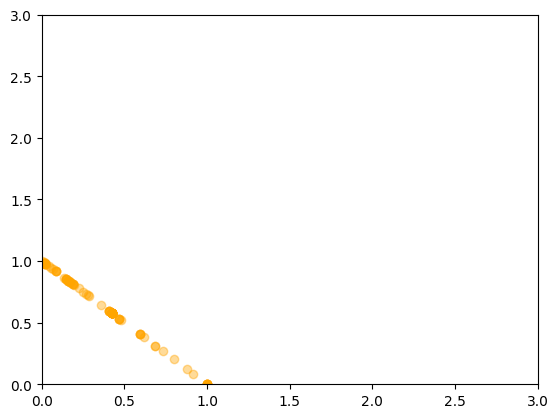

In [15]:
### Pominięcie miary CD
N = 100 # rozmiar populacji
GEN = 600 # liczba generacji/iteracji algorytmu
 
P = constructInitialPopulation(N) # utworzenie populacji początkowej
applyScoresAndSort(P, useCD = False) # posortowanie populacji wykorzystując fronty
# niezdominowane (bez miary cd; useCD = False)

for gen in range(GEN): # iteracja po kolejnych generacjach
    C = constructParents(N) # skonstruowanie identyfikatorów rodziców
    O = constructOffspring(P, C, gen + 1, 0.1) # konstrukcja potomstwa
    M = P + O # połączenie obecnej populacji z potomną
    applyScoresAndSort(M, useCD = False) # posortowanie tak połączonej populacji
    P = M[:N] # "przeżywają najlepiej przystosowani"
    # if gen % (GEN / 4) == 0 or gen == GEN - 1: plotPopul(P) # co jakiś krok ilustrowana jest populacja
    
plotPopul(P)

# wypisanie statystyk
print(getStatsCD(P))

(0.06559466841917029, 0.13838955388831936, 0.04442686926376763, 0.016489215390878723)


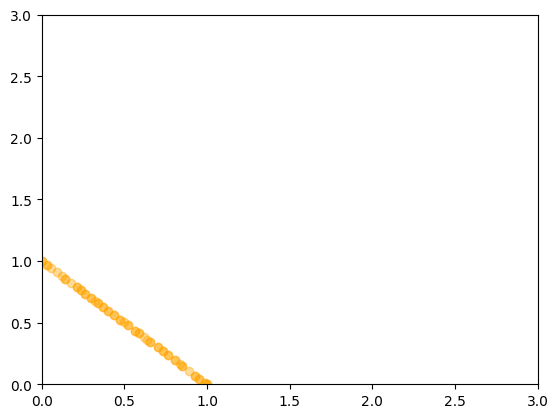

In [16]:
### Pominięcie miary CD
N = 60
GEN = 600

P = constructInitialPopulation(N)
applyScoresAndSort(P, useCD = True)

for gen in range(GEN):
    C = constructParents(N)
    O = constructOffspring(P, C, gen + 1, 0.1)
    M = P + O
    applyScoresAndSort(M, useCD = True)
    P = M[:N]
    # if gen % (GEN / 5) == 0 or gen == GEN - 1: plotPopul(P)

plotPopul(P)

print(getStatsCD(P))